# DE27IM Class Tests

When written in binary, the 27 bit relationship contains 3 9-bit
parts corresponding to DE-9IM relationships. The left-most 9 bits
are the relationship between the second structure's contour and the
first structure's convex hull polygon. The middle 9 bits are the
relationship between the second structure's contour and the first
structure's exterior polygon (i.e. with any holes filled). The
right-most 9 bits are the relationship between the second
structure's contour and the first structure's contour.

Args:
    slice_structures (pd.DataFrame): A table of structures, where
        the values are the contours with type StructureSlice. The
        column index contains the roi numbers for the structures.
        The row index contains the slice index distances.

Returns:
    DE9IM_Type: An integer corresponding to a 27 bit binary value
        reflecting the combined DE-9IM relationship between contour2 and
        contour1's convex hull, exterior and polygon.

## Setup

### Imports

In [2]:
# Shared Packages
import pandas as pd

# Local functions and classes
from types_and_classes import *
from utilities import *
from debug_tools import *
from structure_slice import *
from relations import *

### Global Settings

In [3]:
PRECISION = 2

In [4]:
%matplotlib inline

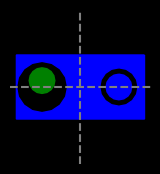

|001|	|111|	|111|
|001|	|001|	|001|
|111|	|001|	|001|

Relationship: Surrounds


In [5]:
def surrounds_example3():
    box10x5 = shapely.Polygon(box_points(10,5))
    circle4_left = shapely.Polygon(circle_points(2, offset_x=-3))
    circle3_right = shapely.Polygon(circle_points(1.5, offset_x=3))
    circle2_left = shapely.Polygon(circle_points(1, offset_x=-3, offset_y=0.5))
    circle2_right = shapely.Polygon(circle_points(1, offset_x=3))
    a = StructureSlice([box10x5, circle4_left, circle3_right, circle2_right])
    b = StructureSlice([circle2_left])
    return a, b

a, b = surrounds_example3()
ax = plot_ab(a.contour, b.contour)

r = DE27IM(a,b)
print(str(r))
print(r.identify_relation())

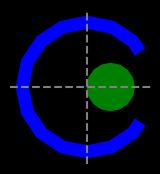

|001|	|001|	|111|
|001|	|001|	|001|
|111|	|111|	|001|

Relationship: Unknown


In [6]:
def shelters_example():
    circle6 = shapely.Polygon(circle_points(3))
    circle5 = shapely.Polygon(circle_points(2.5))
    circle4_offset = shapely.Polygon(circle_points(2, offset_x=3.5))
    shell = shapely.difference(circle6, circle5)
    cove = shapely.difference(shell, circle4_offset)
    circle2 = shapely.Polygon(circle_points(1, offset_x=1))

    a = StructureSlice([cove])
    b = StructureSlice([circle2])
    return a, b

a, b = shelters_example()
ax = plot_ab(a.contour, b.contour)

r = DE27IM(a,b)
print(str(r))
print(r.identify_relation())

In [7]:
poly_a = shapely.Polygon(circle_points(2))
poly_b = shapely.Polygon(circle_points(2))
relation = DE9IM(poly_a, poly_a)
print(relation)
relation

|100|
|010|
|001|


<DE9IM>: 2FFF1FFF2

In [8]:
relation_str = '111000000111000000111000000'
relation_str[9:]

'111000000111000000'

In [9]:
box6 = shapely.MultiPolygon([shapely.Polygon(box_points(6))])
box4 = shapely.MultiPolygon([shapely.Polygon(box_points(4))])
relation = DE9IM(box4, box6)
boundary_relation = relation.boundary_adjustment('b')
print(boundary_relation)
boundary_relation

|010|
|010|
|011|


<DE9IM>: F2FF1FF22

In [10]:
relation_str = '111000000111000000111000000'
de27im = DE27IM(relation_str=relation_str)

In [11]:
DE27IM.test_binaries[7].relation_type


<RelationshipType.EQUALS: 9>

In [12]:
v = DE27IM.test_binaries[7].mask - DE27IM.test_binaries[7].value
v = DE27IM.test_binaries[7].value
de27im = DE27IM(relation_int=v)
de27im.identify_relation()

<RelationshipType.EQUALS: 9>

## Adjusting Boundary Slice Relations

For the beginning and ending slices of a structure the entire contour must
be treated as a boundary.  The structure does not have an interior on these
slices. In this case the “*Interior*” relations become “*Boundary*” relations.

The “*Interior*” bits of the DE-9IM relationship metric are combined with the 
“*Boundary*” bits using "OR" logic.  This keeps the “*Boundary*” bits as 
part of the boundary.

Possible boundary adjustment types are:

<link rel="stylesheet" href="relations.css">
<ul>
<li>The <span class="a">a</span> polygon is from a boundary slice</li>
<li>The <span class="b">b</span> polygon is from a boundary slice</li>
<li>Both the <span class="a">a</span> polygon and 
<span class="b">b</span> polygons are from a boundary slice</li>
</ul>


In [13]:
def surrounds_example2():
    circle6 = shapely.Polygon(circle_points(3))
    circle5 = shapely.Polygon(circle_points(2.5))
    circle4 = shapely.Polygon(circle_points(2))
    circle3 = shapely.Polygon(circle_points(1.5))
    circle2 = shapely.Polygon(circle_points(1))

    a = StructureSlice([circle6, circle5, circle2])
    b = StructureSlice([circle4, circle3])
    return a, b

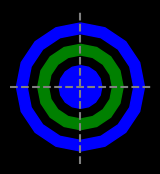

('FF2FF1212', '212FF1FF2', '212FF1FF2')


In [14]:
a, b = surrounds_example2()
plot_ab(a.contour, b.contour)
contour = a.contour.relate(b.contour)
external = a.exterior.relate(b.contour)
convex_hull = a.hull.relate(b.contour)
relation_group = (contour, external, convex_hull)
print(relation_group)

**Original**<br>
|Contour|Exterior|Hull|
|-----|-----|-----|
| FF2 | 212 | 212 |
| FF1 | FF1 | FF1 |
| 212 | FF2 | FF2 |

`('FF2FF1212','212FF1FF2','212FF1FF2')`<br>


**Boundary A Adjustment**<br>
<img src="Images/Boundaries/a interior to boundary.png" style="height:150px;"/><br>
|Contour|Exterior|Hull|
|-----|-----|-----|
| FFF | FFF | FFF |
| FF2 | 212 | 212 |
| 212 | FF2 | FF2 |


`('FFFFF2212','FFF212FF2','FFF212FF2')`<br>
(<DE9IM>: FFFFF2212, <DE9IM>: FFF212FF2, <DE9IM>: FFF212FF2)

**Boundary B Adjustment**<br>
<img src="Images/Boundaries/b interior to boundary.png" style="height:150px;"/><br>
|Contour|Exterior|Hull|
|-----|-----|-----|
| FF2 | F22 | F22 |
| FF1 | FF1 | FF1 |
| F22 | FF2 | FF2 |

`('FF2FF1F22','F22FF1FF2','F22FF1FF2')`<br>


**Both Boundary Adjustments**<br>
<img src="Images/Boundaries/a and b interior to boundary.png" style="height:150px;"/><br>
|Contour|Exterior|Hull|
|-----|-----|-----|
| FFF | FFF | FFF |
| FF2 | F22 | F22 |
| F22 | FF2 | FF2 |

`('FFFFF2F22','FFFF22FF2','FFFF22FF2')`<br>


In [15]:
initial_relation_group = (DE9IM(relation_str='FF2FF1212'),
                          DE9IM(relation_str='212FF1FF2'),
                          DE9IM(relation_str='212FF1FF2'))
print(f'Initial Relation:\t\t\t{initial_relation_group}')

boundary_a_adjustment = (DE9IM(relation_str='FFFFF2212'),
                         DE9IM(relation_str='FFF212FF2'),
                         DE9IM(relation_str='FFF212FF2'))

print(f'After Boundary A Adjustment:\t\t{boundary_a_adjustment}')

boundary_b_adjustment = (DE9IM(relation_str='FF2FF1F22'),
                         DE9IM(relation_str='F22FF1FF2'),
                         DE9IM(relation_str='F22FF1FF2'))
print(f'After Boundary B Adjustment:\t\t{boundary_b_adjustment}')

both_boundary_adjustments = (DE9IM(relation_str='FFFFF2F22'),
                             DE9IM(relation_str='FFFF22FF2'),
                             DE9IM(relation_str='FFFF22FF2'))
print(f'After Both Boundary Adjustments:\t{both_boundary_adjustments}')


Initial Relation:			(<DE9IM>: FF2FF1212, <DE9IM>: 212FF1FF2, <DE9IM>: 212FF1FF2)
After Boundary A Adjustment:		(<DE9IM>: FFFFF2212, <DE9IM>: FFF212FF2, <DE9IM>: FFF212FF2)
After Boundary B Adjustment:		(<DE9IM>: FF2FF1F22, <DE9IM>: F22FF1FF2, <DE9IM>: F22FF1FF2)
After Both Boundary Adjustments:	(<DE9IM>: FFFFF2F22, <DE9IM>: FFFF22FF2, <DE9IM>: FFFF22FF2)


In [16]:
de27im = DE27IM(relation_int=0)
adjusted_de27im = de27im.apply_adjustments(initial_relation_group,
                                           ['boundary_a'])
boundary_a_adjustment = (DE9IM(relation_str='FFFFF2212'),
                         DE9IM(relation_str='FFF212FF2'),
                         DE9IM(relation_str='FFF212FF2'))
print(adjusted_de27im)
print(boundary_a_adjustment)
assert adjusted_de27im == boundary_a_adjustment

(<DE9IM>: FFFFF2212, <DE9IM>: FFF212FF2, <DE9IM>: FFF212FF2)
(<DE9IM>: FFFFF2212, <DE9IM>: FFF212FF2, <DE9IM>: FFF212FF2)


In [17]:
de27im = DE27IM(relation_int=0)
adjusted_de27im = de27im.apply_adjustments(initial_relation_group,
                                           ['boundary_b'])
boundary_b_adjustment = (DE9IM(relation_str='FF2FF1F22'),
                         DE9IM(relation_str='F22FF1FF2'),
                         DE9IM(relation_str='F22FF1FF2'))
print(adjusted_de27im)
print(boundary_b_adjustment)
assert adjusted_de27im == boundary_b_adjustment

(<DE9IM>: FF2FF1F22, <DE9IM>: F22FF1FF2, <DE9IM>: F22FF1FF2)
(<DE9IM>: FF2FF1F22, <DE9IM>: F22FF1FF2, <DE9IM>: F22FF1FF2)


In [18]:
de27im = DE27IM(relation_int=0)
adjusted_de27im = de27im.apply_adjustments(initial_relation_group,
                                           ['boundary_a', 'boundary_b'])
both_boundary_adjustments = (DE9IM(relation_str='FFFFF2F22'),
                             DE9IM(relation_str='FFFF22FF2'),
                             DE9IM(relation_str='FFFF22FF2'))
print(adjusted_de27im)
print(both_boundary_adjustments)
assert adjusted_de27im == both_boundary_adjustments

(<DE9IM>: FFFFF2F22, <DE9IM>: FFFF22FF2, <DE9IM>: FFFF22FF2)
(<DE9IM>: FFFFF2F22, <DE9IM>: FFFF22FF2, <DE9IM>: FFFF22FF2)


## Correcting for Holes

In some cases a relation may be generated for a polygon that is represents a hole (void) in a larger polygon. 

In this case,  the the interior of a hole is the exterior of the structure, but 
the exterior of a hole is undefined. It may or may not be within the interior 
of the larger polygon.

- “*Interior*” relations become “*Exterior*” relations 
- “*Exterior*” relations become “**F**” relations.

- When hole boundaries are tested, only the "contour" “*Boundary*” bits of
    the `DE27IM` relationship are used.  The external and hull bits are set to `'FFFFFFFFF'`.

In [19]:
def shelters_circle():
    circle6 = shapely.Polygon(circle_points(3))
    circle3 = shapely.Polygon(circle_points(1.5, offset_x=1.6))
    crescent = shapely.difference(circle6, circle3)
    circle2 = shapely.Polygon(circle_points(1, offset_x=1.5))

    a = StructureSlice([crescent])
    b = StructureSlice([circle2])
    return a, b

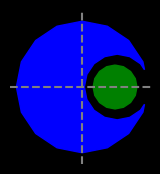

('FF2FF1212', 'FF2FF1212', '212FF1FF2')


In [20]:
a, b = shelters_circle()
plot_ab(a.contour, b.contour)
contour = a.contour.relate(b.contour)
external = a.exterior.relate(b.contour)
convex_hull = a.hull.relate(b.contour)
relation_group = (contour, external, convex_hull)
print(relation_group)

**Original**<br>
|Contour|Exterior|Hull|
|-----|-----|-----|
| FF2 | FF2 | 212 |
| FF1 | FF1 | FF1 |
| 212 | 212 | FF2 |

`('FF2FF1212','FF2FF1212','212FF1FF2')`<br>

**Hole A Adjustment**<br>
<img src="Images\Boundaries\Correction for A as Hole.png" style="height:150px;"/><br>
|Contour|Exterior|Hull|
|-----|-----|-----|
| FFF | FFF | FFF |
| FF1 | FFF | FFF |
| FF2 | FFF | FFF |

**Note:** The exterior and hull relations are not used for hole adjustments.

`('FFFFFFF2','FFFFFFFFF','FFFFFFFFF')`<br>
`('FFFFF1FF2','FFFFFFFFF','FFFFFFFFF')`<br>


**Hole B Adjustment**<br>
<img src="Images/Boundaries/b interior to boundary.png" style="height:150px;"/><br>
|Contour|Exterior|Hull|
|-----|-----|-----|
| FFF | FFF | FFF |
| FFF | FFF | FFF |
| F12 | FFF | FFF |

`('FFFFFFF12','FFFFFFFFF','FFFFFFFFF')`<br>


In [22]:
initial_relation_group = (DE9IM(relation_str='FF2FF1212'),
                          DE9IM(relation_str='FFFFFFFFF'),
                          DE9IM(relation_str='FFFFFFFFF'))

de27im = DE27IM(relation_int=0)
adjusted_de27im = de27im.apply_adjustments(initial_relation_group,
                                           ['hole_a'])
hole_a_adjustment = (DE9IM(relation_str='FFFFF1FF2'),
                     DE9IM(relation_str='FFFFFFFFF'),
                     DE9IM(relation_str='FFFFFFFFF'))
print(adjusted_de27im)
print(hole_a_adjustment)
assert adjusted_de27im == hole_a_adjustment

(<DE9IM>: FFFFF1FF2, <DE9IM>: FFFFFFFFF, <DE9IM>: FFFFFFFFF)
(<DE9IM>: FFFFF1FF2, <DE9IM>: FFFFFFFFF, <DE9IM>: FFFFFFFFF)


In [23]:
initial_relation_group = (DE9IM(relation_str='FF2FF1212'),
                          DE9IM(relation_str='FFFFFFFFF'),
                          DE9IM(relation_str='FFFFFFFFF'))

de27im = DE27IM(relation_int=0)
adjusted_de27im = de27im.apply_adjustments(initial_relation_group,
                                           ['hole_b'])
hole_b_adjustment = (DE9IM(relation_str='FFFFFFF12'),
                     DE9IM(relation_str='FFFFFFFFF'),
                     DE9IM(relation_str='FFFFFFFFF'))
print(adjusted_de27im)
print(hole_b_adjustment)
assert adjusted_de27im == hole_b_adjustment

(<DE9IM>: FFFFFFF12, <DE9IM>: FFFFFFFFF, <DE9IM>: FFFFFFFFF)
(<DE9IM>: FFFFFFF12, <DE9IM>: FFFFFFFFF, <DE9IM>: FFFFFFFFF)


## Secondary Boundary Tests (Transpose Method)
- Regions that are only boundaries of the Secondary ROI also need to be 
  identified and tested in the same way as the Primary ROI.

- It may be easier to implement by reversing the Primary and Secondary ROI and 
then transposing the matrix. 
> `shapely.relate(poly_a, poly_b)` $\equiv$ `shapely.relate(poly_a, poly_b).T`


### Secondary Boundaries
- Boundaries in the Secondary ROI also need to be evaluated as well as the Primary ROI.
- The resulting relation is transposed before being combined with the other relation values.


In [ ]:
def simple_contains_example():
    circle6 = shapely.Polygon(circle_points(3))
    circle4 = shapely.Polygon(circle_points(2))
    a = StructureSlice([circle6])
    b = StructureSlice([circle4])
    return a, b


In [24]:
def confines_ring_example():
    circle6 = shapely.Polygon(circle_points(3))
    circle4 = shapely.Polygon(circle_points(2))
    circle2 = shapely.Polygon(circle_points(1))

    # b has internal borders with the ring portion of a, but has an external
    # border with the island part of a. The internal borders relation wins.
    a = StructureSlice([circle6, circle4, circle2])
    b = StructureSlice([circle4, circle2])
    return a, b

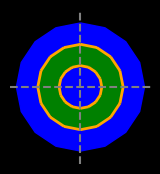

('FF2F112F2', '212FF1FF2', '212FF1FF2')


In [25]:
a, b = confines_ring_example()
plot_ab(a.contour, b.contour)
contour = a.contour.relate(b.contour)
external = a.exterior.relate(b.contour)
convex_hull = a.hull.relate(b.contour)
relation_group = (contour, external, convex_hull)
print(relation_group)

('
FF2
F11
2F2
', '
212
FF1
FF2
', '
212
FF1
FF2
')

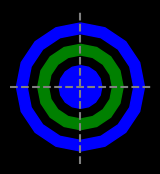

('FF2FF1212', '212FF1FF2', '212FF1FF2')


In [ ]:
a, b = surrounds_example2()
plot_ab(a.contour, b.contour)
contour = a.contour.relate(b.contour)
external = a.exterior.relate(b.contour)
convex_hull = a.hull.relate(b.contour)
relation_group = (contour, external, convex_hull)
print(relation_group)

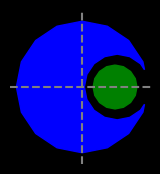

('FF2FF1212', 'FF2FF1212', '212FF1FF2')


In [ ]:
a, b = shelters_circle()
plot_ab(a.contour, b.contour)
contour = a.contour.relate(b.contour)
external = a.exterior.relate(b.contour)
convex_hull = a.hull.relate(b.contour)
relation_group = (contour, external, convex_hull)
print(relation_group)